In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from src.data import preparing_data as preda
from src.data import transform_data as trada
from src.process import cum_return as pcr
from src.visualization import describe_pics as despic

# 市场因子的动态联合分布

## 研究动机

1. 传统的市场因子能够描述市场特征，因为通常因子间并无线性相关关系。但是可以发现因子间存在非线性相关关系。
2. 非线性相关关系带来了研究因子的动态特征及联合分布特征的必要性。
3. 线性因子模型依赖于多维正态分布的假定，但因子分布实际上并非正态的。
4. 综上，需要考虑因子的动态特征以及联合分布特征，决定因子的权重。

## 描述性统计与非线性相关

按照原论文方法，这里使用国泰安数据库中的周频三因子数据（因为周频没有四因子数据）进行研究，时间区间为2000-01-01 至2018-07-15

### 因子的描述性统计

查看三因子的描述性统计信息如下。首先是均值、方差、分位数、偏度与峰度信息。分布有偏，且尖峰厚尾。

In [3]:
facs: pd.DataFrame = preda.read_facs()
preda.describe_df(facs)

,premium,smb,hml
count,888.000000,888.000000,888.000000
mean,0.001154,0.001450,0.000571
std,0.035536,0.024720,0.014608
min,-0.146640,-0.141870,-0.064374
25%,-0.018355,-0.009312,-0.007644
50%,0.000788,0.002530,0.000245
75%,0.020395,0.013742,0.007467
max,0.155446,0.121520,0.081242
skew,-0.065359,-0.721637,0.436881
kurtosis,2.421922,5.572598,3.943337


下面是皮尔逊相关系数的信息。可见因子间的线性相关性并不高；但smb 与hml 之间的相关系数略高。

In [4]:
facs.corr()

,premium,smb,hml
premium,1.000000,0.137774,-0.107155
smb,0.137774,1.000000,-0.578064
hml,-0.107155,-0.578064,1.000000


对三因子画出直方图，可以直观看到其分布特征。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115d69e50>,
      dtype=object)

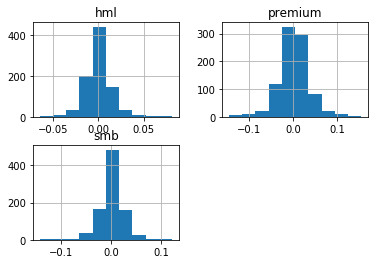

In [5]:
facs.hist()

对因子的历史情况绘图，可以发现其分布也是非对称的。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115dc1510>,
      dtype=object)

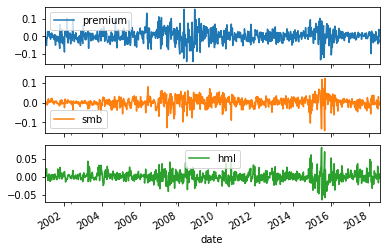

In [6]:
facs.plot(subplots=True)

另外使用qq-plot 查看分布的特征。可以看到其极端值偏离了正态分布。

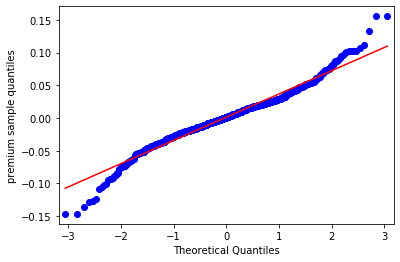

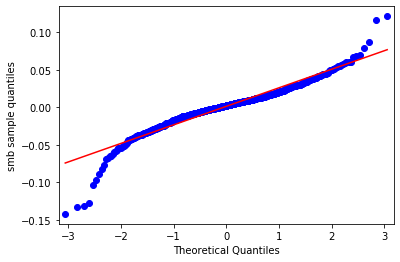

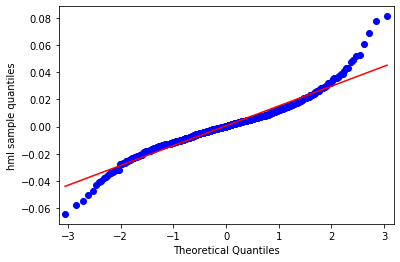

In [7]:
for col in facs.columns:
    sm.qqplot(facs[col], line='s', ylabel=col + ' sample quantiles')

### Threshhold Correlation

根据原文的说法，只有满足多维正态分布成立时，简单的线性相关关系才可以完全刻画因子收益之间的相关关系。验证了其不符合多维正态分布后，就需要探索其非线性相关。

首先是画出标准化后的因子收益散点图矩阵。发现有很多散点对位于极端值部分。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1026c6bd0>,
      dtype=object)

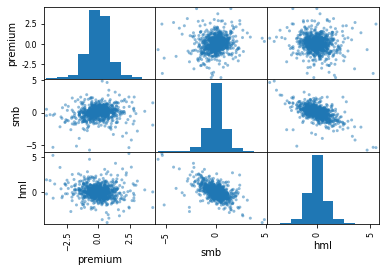

In [8]:
normalize_df = (facs - facs.mean())/facs.std()
pd.plotting.scatter_matrix(normalize_df)

Threshold Correlation 的计算方法如下

$$
\bar{\rho}_{i j}(u)=\left\{\begin{array}{ll}{\operatorname{Corr}\left(r_{i}, r_{j} | r_{i}<F_{i}^{-1}(u), r_{j}<F_{j}^{-1}(u)\right)} & {\text { when } u<0.5} \\ {\operatorname{Corr}\left(r_{i}, r_{j} | r_{i} \geq F_{i}^{-1}(u), r_{j} \geq F_{j}^{-1}(u)\right)} & {\text { when } u \geq 0.5}\end{array}\right.
$$

其中$u$ 是介于0、1 之间的Treshold，$F_{i}^{-1}(u)$ 是$r_i$ 的经验分位数。这一公式计算了位于左下角和右上角极端值处的线性相关关系。二维正态分布的Threshold Correalation 在$u$ 接近0 或1 时趋于0。

下面画出使用该公式的Threshold Correlation 图，这里只画出了符合Threshold 并且至少有20 个因子值对时的情况。绿色线为生成的二维正态分布随机数所画的图。可见因子间并不符合二维正态分布的特征，极端值相关性大于二维正态分布，且普遍看来越趋于极端值时相关性越高。

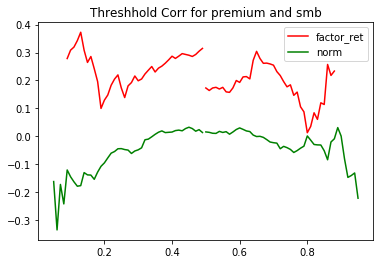

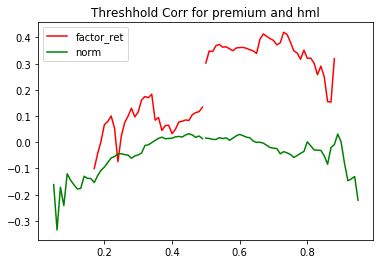

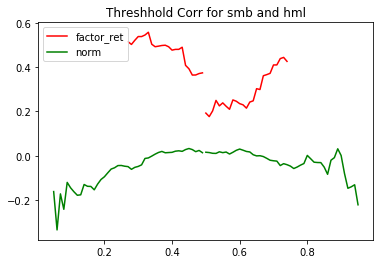

In [9]:
multinorm_ran = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=10000)
multinorm_ran_df: pd.DataFrame = pd.DataFrame(multinorm_ran)
despic.threshhold_corr_plot(facs, colors=['red', 'green'], binorm_rand=multinorm_ran_df)

## 因子的动态特征

各个因子都呈现出自相关特征，同时金融资产收益率量（即绝对值）的相关性往往比其本身更高。使用自相关图画出各个因子本身及其绝对值的自相关图。绝对值上表现出了强自相关。

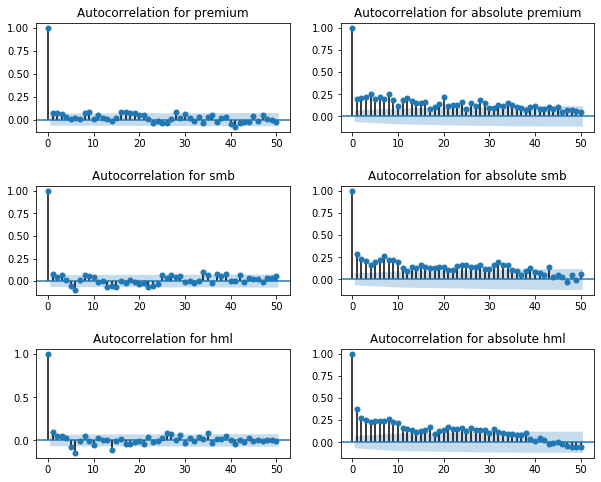

In [10]:
despic.autocorr_func_plot(fac_df=facs)

为了控制自相关问题，这里使用ARMA(3, 0)-eGarch(1, 1) 模型对每个因子进行拟合，这里假定标准化残差服从skew t 分布以获得更好的效果。其中ARMA(3, 0) 模型如下：

$$
r_{j, t}=\phi_{0, j}+\phi_{1, j} r_{j, t-1}+\phi_{2, j} r_{j, t-2}+\phi_{3, j} r_{j, t-3}+\sigma_{j, t} \epsilon_{j, t}
$$

对模型拟合后，画出standarize residual 本身和绝对值的自相关图如下。可以看出，自相关问题已经基本被克服了。

同时，使用ARMA-eGarch 模型进行拟合后，可以获得因子分布情况。

$$
f_{j, t}\left(r_{j, t+1}\right)=\sigma_{j, t+1}^{-1} f_{j}\left(\epsilon_{j, t+1} ; \kappa_{j}, \nu_{j}\right)
$$

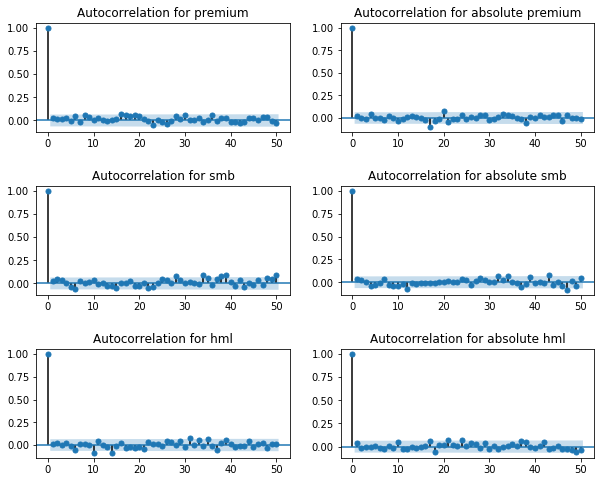

In [11]:
residual: pd.DataFrame = trada.read_garch_stand_residual()
despic.autocorr_func_plot(fac_df=residual)

## 因子间的依赖关系（多维分布）

已知多维分布情况不符合多维正态分布，那么需要对其分布进行探究。使用Copula 模型对其进行建模。根据Copula 模型，任何因子间的联合分布$ f_{t}\left(r_{1, t+1}, \dots, r_{N, t+1}\right) $可以表示为为一个copula function 和因子边际分布之间的乘积。

$$
f_{t}\left(r_{1, t+1}, \ldots, r_{N, t+1}\right)=c_{t}\left(\eta_{1, t+1}, \ldots, \eta_{N, t+1}\right) \prod_{j=1}^{N} f_{j, t}\left(r_{j, t+1}\right)
$$

其中$c_{t}\left(\eta_{1, t+1}, \dots, \eta_{N, t+1}\right)$ 是copula function，其中

$$
\eta_{j, t+1}=F_{j, t}\left(r_{j, t+1}\right)
$$

这里选择使用t copula 进行拟合，估计copula funciton 时，最大化 $ \sum_{t=1}^{T} \ln c\left(\eta_{1, t}, \ldots, \eta_{N, t} ;\nu_{c} ; \Psi\right) $ 来估计参数。其中 $\nu_{c}$ 为自由度参数，$\Psi$ 为copula 的相关系数矩阵。

## 市场实证

使用以上的方法，用ARMA-GARCH 估计未来一周的边际分布，使用t-copula 估计联合分布，最终获得一个联合分布 $f_t(r_t+1)$。

从前两年的数据为开始，向下滚动估计，每个时间点以之前的所有可用数据估计所需参数。其中ARMA-GARCH 模型参数每周估计一次，t-copula 模型的参数每年估计一次。

估计得到联合分布后，在获得因子权重时，求解以下的 CRRA 效用函数：

$$
\begin{aligned} \max _{w_{t}} &=E_{t}\left[U\left(1+r_{f, t+1}+w_{t}^{\top} r_{t+1}\right)\right] \\ &=\int \frac{\left(1+r_{f, t+1}+w_{t}^{\top} r_{t+1}\right)^{1-\gamma}}{(1-\gamma)} f_{t}\left(r_{t+1}\right) d r_{t+1} \end{aligned}
$$

其中 $r_{f, t+1}$ 为无风险收益率，$r_(t+1)$ 为因子收益率，$w_t$ 为权重。同时，原文考虑了使用杠杆时的情况，规定了保证金要求比率(margin requirement, MR) 的限制条件如下。

$$
w_{m a r k e t}+2\left(w_{s i z e}+w_{v a l u e}\right) \leq 1 / M R
$$

其中后面的权重乘2 是因为有long 和short positions 两部分。（为什么？）并且所有的 $w_{t,i}$ 为非负值。

另外根据文章的意思，如果是权重那么和应该为1（但是原文并没有明说这个条件，这里暂且是按照它计算的）。即如下的限制条件：

$$
\sum_{i=1}^{3} w_{t, i} = 1
$$

在解最优化问题时，与原文一致，实际上使用的是根据分布 $f_t(r_{t+1})$ 生成随机数进行模拟，然后根据模拟的数据计算出均值然后最大化。这里生成了 20000 个随机数求解本次问题。


## 投资结果

按照如上的方法，当 $\gamma = 7$，$mr = 0.2$ 时，计算得到权重序列 $w_t$, 那么out of sample 的组合收益为

$$
r_{p,t} = r_f + w_{t-1}^T r_t
$$

计算所得的 $r_{p, t}$ 周收益率序列描述性统计与直方图如下。

In [12]:
ext_ret = pcr.ex_ret_by_weight(gamma=7, mr=0.2, max_r=1, sum1=True, fac_returns=facs)
rf_week = preda.read_rf_df()['week']
full_ret = ext_ret.add(rf_week).dropna()
full_ret.describe()

count    789.000000
mean       0.050395
std        0.023962
min       -0.043823
25%        0.035611
50%        0.047545
75%        0.064133
max        0.161659
dtype: float64

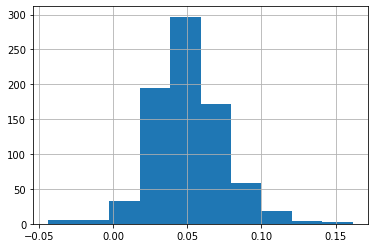

In [13]:
full_ret.hist()

目前的工作就算到这里。接下来的工作包括:

1. 最大化问题并没有确定找到了全局最大化解，目前依然有提高函数值的可能。

2. 最优化问题中的 $\gamma$ 取不同值，限制条件中的 $mr$ 取不同的值。原文中 $\gamma$ 分别取了3、7、10；$mr$ 分别取了0.2 和0.5。但每轮最优化耗时过长（一组参数值换不同的solver 解两次大概需要 24 小时），目前只算完了 $\gamma = 7, mr = 0.2$ 的情况。

3. 计算策略的 certainty equivalent

下面的几项是难度比较大或者工程比较耗时的工作，如果以上内容还不够，或者以下内容很有必要的话会考虑进行：

1. 根据非对称的 threshold correlation，实际上使用skew t copula 比t copula 效果更好，但是因为没有现成的skew t copula 命令，需要自己从头写，如果做这部分的话数学问题难度比较大，需要更多时间。

2. 原文中有一个同时画出Garch 模型的standarize residual 和copula 的implied threshold correlation 的图形，以此表示copula 模型捕捉到了一部分的threshold corrlation。但是文章并没有说明copula 模型隐含相关系数的算法，网上也没有找到类似的说法和命令，所以这里还没有算。

目前不太清楚的几个问题：

1. 文中所指的 weight $w_{t,i}$ 是和为1 的比例值，还是单纯的系数。即最优化时需不需要条件 $\sum_{i=1}^{3} w_{t, i} = 1$？ 

2. 条件 $w_{m a r k e t}+2\left(w_{s i z e}+w_{v a l u e}\right) \leq 1 / M R$ 具体的含义是什么？如果因为有 long 和 short 而乘 2 不是意味着 long、short 组合的权重 $w$ 是一样的吗？